In [1]:
from transformers import RobertaTokenizer
import torch

In [3]:
torch.cuda.is_available()

True

## Distributions

In [4]:
import nltk
import seaborn as sns
import os

<AxesSubplot:ylabel='Density'>

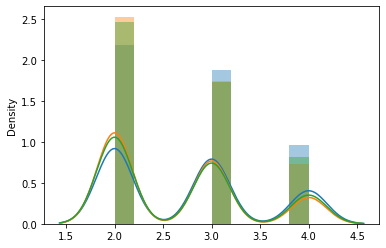

In [5]:

def get_lines_len(dataset):
    data_path = os.path.join(os.getcwd(), 'data', dataset)

    with open(data_path, 'r') as f:
        lines_len = [len(nltk.sent_tokenize(line)) for line in f.readlines()]

    return lines_len

sns.distplot(get_lines_len('train.src'))
sns.distplot(get_lines_len('dev.src'))
sns.distplot(get_lines_len('test.src'))


<AxesSubplot:ylabel='Density'>

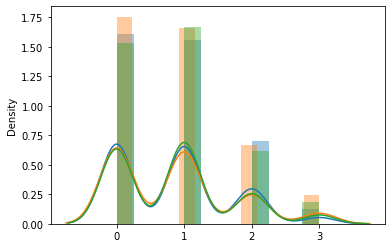

In [6]:
def get_c_pos(dataset):
    data_path = os.path.join(os.getcwd(), 'data', dataset)

    with open(data_path, 'r') as f:
        
        lines = f.readlines()

        C_pos = []
        for line in lines:

            C_list = [i for i,x in enumerate(line.strip().split(' ')) if x=='C']

            assert len(C_list)<=1
            
            C_pos.extend(C_list)
        

    return C_pos


sns.distplot(get_c_pos('train.lbl'))
sns.distplot(get_c_pos('dev.lbl'))
sns.distplot(get_c_pos('test.lbl'))

## Real world predictions

Find cases from test set where your model had failed and visualize them  in  an  impressive  manner.

In [2]:
from model import UpperSentDetectorModel
from dataset import UpperSentDetectorDataset, sent_labels_ids_to_str, sent_labels_str_to_ids
from transformers import RobertaTokenizer
from torch.utils.data import DataLoader
import torch

from utils import *

import random
random.seed(100)

In [5]:
!pip install columnar
from columnar import columnar

You should consider upgrading via the 'pip install --upgrade pip' command.


In [24]:
input_data = 'data/test.src'
input_lbl = 'data/test.lbl'
model_path = './model/best_model.pkl'


tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
test_dataset = UpperSentDetectorDataset(tokenizer)
test_dataset.load(input_data, input_lbl)
test_dataloader = DataLoader(test_dataset, batch_size=5)
model = torch.load(model_path)

pred_labels = model.predict_labels(test_dataloader, 0.9)
out_labels = [sent_labels_ids_to_str(sent_labels)
              for sent_labels in pred_labels]

Data items loaded: 1000
Labels loaded loaded: 1000
INFERENCE: 100%|██████████| 200/200 [05:31<00:00,  1.66s/it]


In [48]:
flatten_pred_labels = flatten_list(pred_labels)
flatten_true_labels = flatten_list(test_dataset.sent_labels)

len(flatten_pred_labels), len(flatten_true_labels)

(2671, 2671)

### Nice data to play with *get_tp_tn_fp_fn*

In [51]:
comparator_list = [list(a) for a in zip(flatten_true_labels,flatten_pred_labels)]

In [69]:
def get_tp_tn_fp_fn(true_labels, pred_labels):
    
    comparator_list = [list(a) for a in zip(true_labels,pred_labels)]

    # https://en.wikipedia.org/wiki/F-score
    def f_beta(tp, tn, fp, fn, beta):
        return (1+beta**2)*tp/((1+beta**2)*tp+(beta**2)*fn+fp)

    tp = len([1 for el in comparator_list if el[0]==el[1] and el[1]])

    tn = len([1 for el in comparator_list if el[0]==el[1] and not el[1]])

    fp = len([1 for el in comparator_list if el[0]!=el[1] and el[1]])

    fn = len([1 for el in comparator_list if el[0]!=el[1] and not el[1]])

    f1 = f_beta(tp, tn, fp, fn, 1)

    f05 = f_beta(tp, tn, fp, fn, .5)

    assert sum([tp, tn, fp, fn]) == len(comparator_list)

    return f05, f1, tp, tn, fp, fn

f05, f1, tp, tn, fp, fn = get_tp_tn_fp_fn(flatten_true_labels,flatten_pred_labels)

f05, f1, tp, tn, fp, fn

(0.992442322991249, 0.9900793650793651, 499, 2162, 3, 7)

In [70]:
from sklearn.metrics import precision_recall_fscore_support

_, _, f_score, _ = \
        precision_recall_fscore_support(flatten_true_labels,
                                        flatten_pred_labels,
                                        average='binary', beta=0.5)

f_score-f05

-1.1102230246251565e-16

In [87]:
lines = []
with open(input_data, 'r') as f:
    lines = [split_sentences(line) for line in f.readlines()]

flatten_lines = flatten_list(lines)

In [93]:
misclassified_cases = [[bool(comp[0]),bool(comp[1]),flatten_lines[i]] for i, comp in enumerate(comparator_list) if comp[0]!=comp[1]]
misclassified_cases

table =  columnar(misclassified_cases, ['Golden','Predicted', 'Text'])
print(table)

|------|---------|-------------------------------------------------------------|
|Golden|Predicted|Text                                                         |
|==============================================================================|
|False |True     |Learning.                                                    |
|------|---------|-------------------------------------------------------------|
|True  |False    |THE BALANCE IN THE CONFLICT BETWEEN  RATIONALITY AND EMOTION |
|      |         |IS CHANGING: “RECEIVED WISDOM, BOTH OF THE EVERYDAY  SORT AND|
|      |         | THE ACADEMIC VARIETY, IS AT LAST MOVING AWAY FROM THE IDEA T|
|      |         |HAT  EMOTION IS TO BE CONTRASTED WITH REASON AND THEN IGNORED|
|      |         | AS IRRELEVANT”  (STRONGMAN, 2003).                          |
|------|---------|-------------------------------------------------------------|
|False |True     |and many others.                                             |
|------|---------|----------

Find  ten  random  parapraphs  from news  websites,  capitalize  one  sentence  in  half  of  them,  run  through your system and visualize

In [5]:
news = ["He visited Atlanta, Georgia, to campaign for the Democrats in next month's Senate run-off elections. Two seats will be decided on 5 January and could determine whether or not his party takes control of the chamber. Democrats already control the House of Representatives.",

"They will give cover to other members of Congress who may have been holding their tongues lest they draw Donald Trump's ire. It may allow the presidential transition process to unroll in a more traditional manner - at least where relations between Congress and the incoming administration are concerned.",

"Now the waiting for the Trump response begins. Will he shrug off Mr McConnell's words or add him to the growing list of enemies within his own party that must be confronted and condemned? The president's next words and actions could reveal the depth of the political turmoil facing the party in the days ahead.",

"If the Democrats win both seats, the Senate will be evenly divided - but it will still be a win for the Democrats. US vice-presidents have the power to cast tie-breaking votes in the Senate, meaning that with Vice-President-elect Harris on board, Democrats would effectively control both chambers.",

"\"I have personally known both 'Santa' and 'Mrs. Claus' my entire life and I can assure everyone that they would have never knowingly done anything to place any children in danger,\" Parker said. \"They have both filled these roles for many years, and bringing joy to children during the holidays is one of the most important parts of their lives.\"",

"The tracks varied in length. One decoy traveled under 50 meters (160 feet) to the nearest beach house, one moved two kilometers (just over a mile) to the nearest bar, while another went 137 kilometers (85 miles) inland, providing solid evidence of the turtle egg trade.",

"However, before the decoy eggs can be used effectively for conservation and law enforcement some hurdles remain. Paso Pacifico are working to extend the eggs' battery life, which only lasts for a few days when the eggs are sending hourly location alerts.",

"When I and my companion realized that we would have to wear these masks all the time, we got depressed. It was hard for us to see, listen and feel, we could hardly do anything. But since we discovered the clear mask, our lives have really improved. All of a sudden we can do whatever we want, and all our senses have come back and are rejoicing.",

"Unbelievable, I feel human again! Very comfortable, light and easy to clean. I would say this is a massive improvement over a fabric mask. If we all wore them, I think it would make it a little less miserable! Everyone asks me where I got it, because that's what they want too!",

"It is another process of reducing inflection from words. The way its different from stemming is that it reduces words to their origins which have actual meaning. Stemming sometimes generates words which are not even words."]

In [6]:
data = []
labels = []

for i in range(len(news)):
    
    sent_list = split_sentences(news[i])
    sent_len = len(sent_list)
    labels_list = [0]*sent_len

    # to upper
    if i%2:
        sent_upper_id = random.randint(0, sent_len-1)
        labels_list[sent_upper_id] = 1
        sent_list[sent_upper_id] = sent_list[sent_upper_id].upper()
    
    data.append(" ".join(sent_list))
    labels.append(sent_labels_ids_to_str(labels_list))

print(data[7])
print(labels[7])

When I and my companion realized that we would have to wear these masks all the time, we got depressed. IT WAS HARD FOR US TO SEE, LISTEN AND FEEL, WE COULD HARDLY DO ANYTHING. But since we discovered the clear mask, our lives have really improved. All of a sudden we can do whatever we want, and all our senses have come back and are rejoicing.
O C O O


In [7]:
input_data = './data/real.src'
input_labels = './data/real.lbl'
with open(input_data, 'w') as f:
    f.writelines('\n'.join(data))

with open(input_labels, 'w') as f:
    f.writelines('\n'.join(labels))

In [3]:
input_data = 'data/real.src'
model_path = './model/best_model.pkl'


tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
test_dataset = UpperSentDetectorDataset(tokenizer)
test_dataset.load(input_data)
test_dataloader = DataLoader(test_dataset, batch_size=5)
model = torch.load(model_path)

pred_labels = model.predict_labels(test_dataloader, 0.9)
out_labels = [sent_labels_ids_to_str(sent_labels)
              for sent_labels in pred_labels]


Data items loaded: 10
INFERENCE: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


In [6]:

table =  columnar([list(a) for a in zip(out_labels,out_labels)], ['Golden','Predicted'])
print(table)

|---------|---------|
|Golden   |Predicted|
|===================|
|O O O    |O O O    |
|---------|---------|
|C O      |C O      |
|---------|---------|
|O O O    |O O O    |
|---------|---------|
|O C      |O C      |
|---------|---------|
|O O O    |O O O    |
|---------|---------|
|O C      |O C      |
|---------|---------|
|O O      |O O      |
|---------|---------|
|O C O O  |O C O O  |
|---------|---------|
|O O O O O|O O O O O|
|---------|---------|
|O O C    |O O C    |
|---------|---------|

